## Rakeshwer's Master Thesis 2022: 

### "Time Series Prediction with ANNs on non-linear and non-stationary Time Series"

**Note:** Former working title was slightly different: "Predicting Regime Shifts for non-linear and non-stationary Time Series with Artificial Neural Networks".

**EXCURSUS:**

This experiment is inspired by results from *notebook 02*, where we tried to find phases with higher / lower prediction accuracy from un-even number of multi-run experiments as **ensemble** predictor. But there we only sticked to rel. chg. of SP500 closing price as only input feature - and failed.

Now we extend this and include VIX (CBOT volatility) as additional feature.

**Outline:**

- import new data: sp500_vix.csv
- repeat multi-run experiment: 11 runs of CNN/fc model with SP500 close (rel chg) as input on target 20d.
- get binary target: high/low reliability
- try to predict high/low reliability (binary target) from VIX as only input feature

### Tech Preamble

In [1]:
import sys
import datetime
import numpy as np
from os.path import join
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import TimeDistributed, Input, Dense, Conv1D, Conv2D, AveragePooling1D, MaxPooling1D, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization, GaussianNoise, LeakyReLU
from tensorflow.keras.layers import concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, Adagrad, Nadam, RMSprop, schedules
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.datasets as tfds
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

### Import data

In [2]:
# Define path to data folder:
path_to_data = "../data"

# Import data from csv file:
data = np.genfromtxt(join(path_to_data,'sp500_vix.csv'), delimiter=';', skip_header=1)

In [3]:
# Check dimensions:
print("data shape (samples, features): ", data.shape)
print("\nfirst row: \n", data[0])

print("\nfeatures [column number]:")
print("=========================")
print("[0] - year")
print("[1] - sp500 close (abs)")
print("[2] - sp500 close (rel chg)")
print("[3] - vix close (abs)") 
print("[4] - vix close (rel chg)")
print("[5] - target 1d (rel chg)")
print("[6] - target 5d (rel chg)")
print("[7] - target 10d (rel chg)")
print("[8] - target 20d (rel chg)")

data shape (samples, features):  (8218, 9)

first row: 
 [ 1.9900000e+03  3.5876000e+02 -2.5855600e-03  1.8190001e+01
  5.5104466e-02 -8.6130000e-03 -3.1915487e-02 -5.9538410e-02
 -8.2729401e-02]

features [column number]:
[0] - year
[1] - sp500 close (abs)
[2] - sp500 close (rel chg)
[3] - vix close (abs)
[4] - vix close (rel chg)
[5] - target 1d (rel chg)
[6] - target 5d (rel chg)
[7] - target 10d (rel chg)
[8] - target 20d (rel chg)


In [4]:
# Extract year for seperating data into train / validation / test sets
year = data[:,0]

## Extract sp500 and vix close (rel chg) as input features.
# [2] - sp500 close (rel chg) 
# [4] - vix close (rel chg)

inputs = data[:,(2,4)]

## Extract target values for 1d / 5d / 10d / 20d as rel chg:
# [5] - target 1d (rel chg)
# [6] - target 5d (rel chg)
# [7] - target 10d (rel chg)
# [8] - target 20d (rel chg)

targets = data[:,5:]

# Check dimensions:
print("year shape (samples): ", year.shape)
print("inputs shape (samples, input features): ", inputs.shape)
print("targets shape (samples, output features): ", targets.shape)

year shape (samples):  (8218,)
inputs shape (samples, input features):  (8218, 2)
targets shape (samples, output features):  (8218, 4)


### Define function to split data, custom loss and evaluation metrics

In [5]:
# Define function to split time series 'sequence' into 'n_steps'
def split_sequence(sequence, n_steps):
    X = list()
    for i in range(len(sequence)):
        # Find the end of this pattern
        end_ix = i + n_steps
        # Check if we are beyond the sequence
        if end_ix > len(sequence):
            break
        # Gather input and output parts of the pattern
        seq_x = sequence[i:end_ix]
        X.append(seq_x)
    return np.array(X)

In [6]:
### Define custom loss function and evaluation metrics:


## Our trading model would imply going "long" if the model predicts an up movement and going "short" else.

# If prediction and target have same sign, we are actually not losing money, which should be reflected as 
# zero loss in the loss function. Whereas using the classical mse loss would assign a positive loss value if
# prediction and target point in the same direction - but deviate.
# In our trading model we only lose money if the prediction was indicating an up movement and the market declines.
# In this case we have a negative target value and we find loss = -target (to have a positive loss value).
# In addition to that we have a second scenario where we lose money: If the model indicated a down movement and
# the market gains, we have a positive target value that equals the loss. Hence loss = target (positive loss value).

# This is encountered in the following customized loss function:
def custom_loss(y_true, y_pred):
    
    # Get sign of targets (y_true)
    eval = K.sign(y_true)
    
    # Need to switch dtype to float32:
    eval = K.cast(eval, dtype='float32')
    
    # Get boolean expression: target != prediction?
    eval = K.not_equal(eval, K.sign(y_pred))
    
    # Convert boolean expression to float32
    eval = K.cast(eval, dtype='float32')
    
    # Multiply with targets (y_true), again need to switch dtype to fload32
    eval = eval * K.cast(K.abs(y_true), dtype='float32')
    
    return eval


# Try instead to adjust the classical mse loss: It shall have non-zero loss only if prediction and target deviate.
# Do this with a mask.
def custom_mse(y_true, y_pred):
    
    # Calculate mse as squared deviation of predictions from targets:
    mse = K.square(y_true - y_pred)
    
    # Need to switch dtype to float32:
    mse = K.cast(mse, dtype='float32')
    
    # Get sign of predictions (y_pred)
    eval1 = K.sign(y_pred)
            
    # Get sign of targets (y_true)
    eval2 = K.sign(y_true)
    
    # Need to switch dtype to float32:
    eval2 = K.cast(eval2, dtype='float32')
    
    # Get boolean expression: target != prediction?
    mask = K.not_equal(eval1, eval2)
    mask = K.cast(mask, dtype='float32')
    
    # Get adjusted mse:
    eval = mask * mse
    
    return eval


# According to our trading model (described above), we can define the gain function for our strategy:
def gain(y_true, y_pred):
    
    eval = K.sign(y_pred) * y_true
    
    return eval


# The outperformance compared to the naive buy-and-hold strategy is given by:
def outperformance(y_true, y_pred):
    
    eval = (K.sign(y_pred) - 1) * y_true
    
    return eval


# And the accuracy is given by:
def accuracy(y_true, y_pred):
    
    # Get sign of targets (y_true)
    eval = K.sign(y_true)
    
    # Need to switch dtype to float32:
    eval = K.cast(eval, dtype='float32')
    
    # Get boolean expression: target == prediction?
    eval = K.equal(eval, K.sign(y_pred))
    
    # Convert boolean expression to float32
    eval = K.cast(eval, dtype='float32')
    
    return eval

### Define functions for CNN/fc model

In [7]:
def set_CNN_fc(CNN_filters, CNN_kernel_sizes, fc_units, 
           n_epochs, batch_size, learning_rate, loss_function):
    """
    Sets up CNN/fc model. Can be used for multi-run experiments.
    
    Parameters:
    ===========
    CNN_filters: Array of integer numbers to specify the number of feature maps in all CNN layers.
    CNN_kernel_sizes: Array of integer numbers to specify the filter sizes in all CNN layers.
    fc_units: Array of integer numbers to specify the number of units in all hidden fc layers.
    n_epochs: Integer number to specify the number of epochs for a single run.
    batch_size: Integer number to specify the batch size used for training the model.
    learning_rate: Floating point number to set the learning rate for the optimizer.
    loss_function: String ('mse', 'custom_mse', 'custom_loss') to choose the loss function.
    
    Returns:
    ========
    model
    
    """
    
    # Start model definition:
    model = Sequential()
    
    # Add input layer:
    input_shape = (input_length, len(input_features))
    model.add(Input(shape=input_shape))
    
    # Add CNN layer(s):
    for i in range(len(CNN_filters)):
        model.add(Conv1D(filters=CNN_filters[i], kernel_size=CNN_kernel_sizes[i], strides=1,
                         kernel_initializer=weight_init, bias_initializer = bias_init))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.3))
        
        # Add max pooling, if input_length is equal or above 40d to limit number of trainable parameters:
        if input_length >= 40:
            model.add(MaxPooling1D(pool_size=2))
    
    # Flatten CNN output:
    model.add(Flatten())
    
    # Add hidden fc layer(s):
    for i in range(len(fc_units)):
        model.add(Dense(units=fc_units[i], activation = 'sigmoid',
                        kernel_initializer=weight_init, bias_initializer = bias_init))
    
    # Add output unit:
    model.add(Dense(units=1, name = "output", activation = 'linear',
                    kernel_initializer=weight_init, bias_initializer = bias_init))

    # Compile model with desired loss function:
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=loss_function,
                  metrics=([]))
#                  metrics=(['mse', custom_mse, custom_loss, gain, outperformance, accuracy]))
   
    return model

### Pre-process inputs and targets, define model parameters, single-run model

In [8]:
## Set parameters:

# Data pre-processing:
input_features = (0,) # 0: sp500 close (rel. chg.), 1: vix close (rel. chg.)
target_horizon = (0,) # 0: 1d, 1: 5d, 2: 10d, 3: 20d
input_length = 20

# Model parameters:
weight_init = tfi.glorot_uniform() # Taken as default.
bias_init = tfi.Zeros() # Taken as default.
CNN_filters = [10,20]
CNN_kernel_sizes = [5,5]
fc_units = [20,10]
LSTM_units = [20,10]
n_epochs = 10
batch_size = 20
learning_rate = 0.0001
loss_function = 'mse' # ('mse', custom_mse or custom_loss) to choose the loss function.

In [11]:
# Select specified input features:
inputs_selected = inputs[:,input_features]

# Select target horizon:
target_selected = targets[:, target_horizon]

# Split input values into sequences of specified input length:
inputs_split = split_sequence(inputs_selected, input_length)

# Adjust data, year and targets: Cut first (input_length - 1) entries
data_cut = data[input_length-1:]
year_cut = year[input_length-1:]
target_cut = target_selected[input_length-1:]

In [12]:
## Split inputs and targets into train / validation / test sets, according to year:

# Train data: 1990 .. 2009
# Val data:   2010 .. 2019
# Test data:  2020 .. end

train_input = inputs_split[year_cut <= 2009]
val_input = inputs_split[(year_cut >= 2010) & (year_cut < 2020)]
test_input = inputs_split[year_cut >= 2020]

train_target = target_cut[year_cut <= 2009]
val_target = target_cut[(year_cut >= 2010) & (year_cut < 2020)]
test_target = target_cut[year_cut >= 2020]

# Convert to binary targets (up = 1, down = 0):
train_target_bin = (train_target>0).astype(int)
val_target_bin = (val_target>0).astype(int)
test_target_bin = (test_target>0).astype(int)

# Check dimensions:
print("train_input shape (samples, time steps, features): ", train_input.shape)
print("val_input shape (samples, time steps, features): ", val_input.shape)
print("test_input shape (samples, time steps, features): ", test_input.shape)
print("\ntrain_target shape (samples, features): ", train_target.shape)
print("val_target shape (samples, features): ", val_target.shape)
print("test_target shape (samples, features): ", test_target.shape)
print("\ntrain_target_bin shape (samples, features): ", train_target_bin.shape)
print("val_target shape_bin (samples, features): ", val_target_bin.shape)
print("test_target shape_bin (samples, features): ", test_target_bin.shape)

train_input shape (samples, time steps, features):  (5023, 20, 1)
val_input shape (samples, time steps, features):  (2516, 20, 1)
test_input shape (samples, time steps, features):  (660, 20, 1)

train_target shape (samples, features):  (5023, 1)
val_target shape (samples, features):  (2516, 1)
test_target shape (samples, features):  (660, 1)

train_target_bin shape (samples, features):  (5023, 1)
val_target shape_bin (samples, features):  (2516, 1)
test_target shape_bin (samples, features):  (660, 1)


In [86]:
# # Alternatively split data into train and validation sets RANDOMLY, and not by YEAR!
# train_input, val_input, train_target, val_target = train_test_split(
#     inputs_split, target_cut, test_size=0.33, random_state=42)

# # Convert to binary targets (up = 1, down = 0):
# train_target_bin = (train_target>0).astype(int)
# val_target_bin = (val_target>0).astype(int)

# # Check dimensions:
# print("train_input shape (samples, time steps, features): ", train_input.shape)
# print("val_input shape (samples, time steps, features): ", val_input.shape)
# print("\ntrain_target shape (samples, features): ", train_target.shape)
# print("val_target shape (samples, features): ", val_target.shape)
# print("\ntrain_target_bin shape (samples, features): ", train_target_bin.shape)
# print("val_target shape_bin (samples, features): ", val_target_bin.shape)

In [13]:
# Get min and max for ALL input features from TRAIN data:
train_min = np.min(train_input, axis=(0,1))
train_max = np.max(train_input, axis=(0,1))

# Apply min max scaling to train / val / test inputs: Substract min and divide by (max - min)
train_input_scaled = (train_input - train_min) / (train_max - train_min)
val_input_scaled = (val_input - train_min) / (train_max - train_min)
test_input_scaled = (test_input - train_min) / (train_max - train_min)

# Check result:
print("train_input MIN: ", np.round(np.min(train_input_scaled, axis=(0,1)), 2))
print("train_input MAX: ", np.round(np.max(train_input_scaled, axis=(0,1)), 2))
print("\nval_input MIN: ", np.round(np.min(val_input_scaled, axis=(0,1)), 2))
print("val_input MAX: ", np.round(np.max(val_input_scaled, axis=(0,1)), 2))
print("\ntest_input MIN: ", np.round(np.min(test_input_scaled, axis=(0,1)), 2))
print("test_input MAX: ", np.round(np.max(test_input_scaled, axis=(0,1)), 2))

train_input MIN:  [0.]
train_input MAX:  [1.]

val_input MIN:  [0.12]
val_input MAX:  [0.68]

test_input MIN:  [-0.14]
test_input MAX:  [0.89]


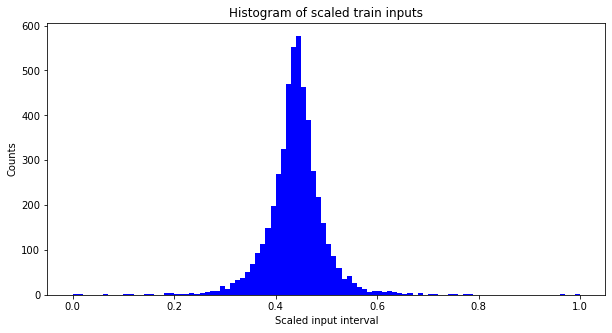

In [20]:
# Plot histogram of scaled inputs: Feature 1 (sp500 close (rel chg))
nBins = 100
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.hist(train_input_scaled[:,0,0], nBins, color="blue")
axes.set_xlabel("Scaled input interval")
axes.set_ylabel("Counts")
axes.set_title("Histogram of scaled train inputs")
plt.show()

In [13]:
## ONLY if we have second input feature!

# # Plot histogram of scaled inputs: Feature 2 (vix close (rel chg))
# nBins = 100
# fig, axes = plt.subplots(1, 1, figsize=(10,5))
# axes.hist(train_input_scaled[:,0,1], nBins, color="blue")
# axes.set_xlabel("Scaled input interval")
# axes.set_ylabel("Counts")
# axes.set_title("Histogram of scaled train inputs")
# plt.show()

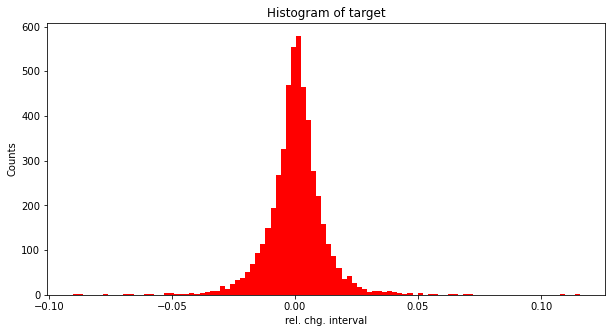

In [21]:
# Plot histogram of targets
nBins = 100
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.hist(train_target[:,0], nBins, color="red")
axes.set_xlabel("rel. chg. interval")
axes.set_ylabel("Counts")
axes.set_title("Histogram of target")
plt.show()

In [22]:
# Set up compiled CNN/fc model:
model = set_CNN_fc(CNN_filters, CNN_kernel_sizes, fc_units, n_epochs, batch_size, learning_rate, loss_function)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16, 10)            60        
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 10)            40        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 10)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12, 20)            1020      
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 20)            80        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 12, 20)            0         
_________________________________________________________________
flatten (Flatten)            (None, 240)               0

2022-09-15 08:32:12.445510: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
# Train model on scaled inputs and un-scaled targets:
history = model.fit(train_input_scaled, train_target, epochs=n_epochs, batch_size=batch_size,
                    shuffle=True, verbose=2, validation_data=(val_input_scaled, val_target))

2022-09-15 08:32:16.171932: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/10
252/252 - 1s - loss: 0.1191 - mse: 0.1191 - custom_mse: 0.0657 - custom_loss: 0.0041 - gain: -2.2704e-04 - outperformance: -5.4569e-04 - accuracy: 0.4698 - val_loss: 0.0530 - val_mse: 0.0530 - val_custom_mse: 0.0305 - val_custom_loss: 0.0034 - val_gain: -4.6322e-04 - val_outperformance: -9.2644e-04 - val_accuracy: 0.4511
Epoch 2/10
252/252 - 0s - loss: 0.0046 - mse: 0.0046 - custom_mse: 0.0029 - custom_loss: 0.0041 - gain: -2.4322e-04 - outperformance: -5.6187e-04 - accuracy: 0.4776 - val_loss: 7.9481e-04 - val_mse: 7.9481e-04 - val_custom_mse: 5.4408e-04 - val_custom_loss: 0.0033 - val_gain: -2.8499e-04 - val_outperformance: -7.4821e-04 - val_accuracy: 0.4646
Epoch 3/10
252/252 - 0s - loss: 0.0019 - mse: 0.0019 - custom_mse: 0.0013 - custom_loss: 0.0039 - gain: -1.2992e-05 - outperformance: -3.3164e-04 - accuracy: 0.5059 - val_loss: 0.0012 - val_mse: 0.0012 - val_custom_mse: 7.2326e-04 - val_custom_loss: 0.0031 - val_gain: 2.8234e-04 - val_outperformance: -1.8088e-04 - val_

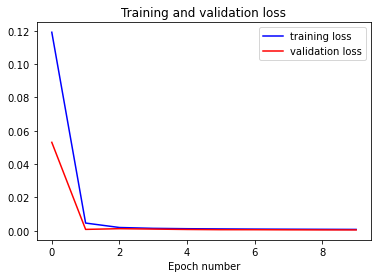

In [24]:
# Plot train and val_loss (mse)
plt.plot(history.history['loss'], color = 'blue', label = 'training loss')
plt.plot(history.history['val_loss'], color = 'red', label = 'validation loss')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('Training and validation loss')
plt.legend()
plt.show() 

In [34]:
# Get model predictions:
train_pred = model.predict(train_input_scaled)
val_pred = model.predict(val_input_scaled)
test_pred = model.predict(test_input_scaled)

# Convert to binary prediction UP (1) / DOWN (0):
train_pred_bin = (train_pred>0).astype(int)
val_pred_bin = (val_pred>0).astype(int)
test_pred_bin = (test_pred>0).astype(int)

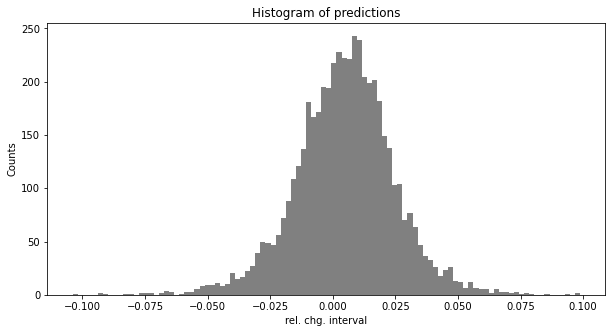

In [37]:
# Plot histogram of predictions
nBins = 100
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.hist(train_pred[:,0], nBins, color="grey")
axes.set_xlabel("rel. chg. interval")
axes.set_ylabel("Counts")
axes.set_title("Histogram of predictions")
plt.show()

In [31]:
# Get custom loss, gain, outperformance and accuracy for validation samples:
val_custom_mse = custom_mse(val_target, val_pred)
val_custom_loss = custom_loss(val_target, val_pred)
val_gain = gain(val_target, val_pred)
val_outperformance = outperformance(val_target, val_pred)
val_accuracy = accuracy(val_target, val_pred)

# Check val. target vs. prediction for first 10 validation samples, vs. custom loss, gain, outperformance and acc:
print("         target | prediction | custom mse | custom loss | gain | outperformance | accuracy")
np.concatenate([val_target[:10],val_pred[:10],val_custom_mse[:10],val_custom_loss[:10],
                val_gain[:10],val_outperformance[:10],val_accuracy[:10]],axis=-1)

         target | prediction | custom mse | custom loss | gain | outperformance | accuracy


array([[ 3.11565000e-03,  5.28171659e-04,  0.00000000e+00,
         0.00000000e+00,  3.11565003e-03,  0.00000000e+00,
         1.00000000e+00],
       [ 5.45525000e-04,  3.56900841e-02,  0.00000000e+00,
         0.00000000e+00,  5.45524992e-04,  0.00000000e+00,
         1.00000000e+00],
       [ 4.00126600e-03,  6.38931990e-04,  0.00000000e+00,
         0.00000000e+00,  4.00126586e-03,  0.00000000e+00,
         1.00000000e+00],
       [ 2.88169300e-03,  2.13325471e-02,  0.00000000e+00,
         0.00000000e+00,  2.88169296e-03,  0.00000000e+00,
         1.00000000e+00],
       [ 1.74675500e-03,  9.66283679e-03,  0.00000000e+00,
         0.00000000e+00,  1.74675498e-03,  0.00000000e+00,
         1.00000000e+00],
       [-9.38115700e-03,  9.73077118e-03,  3.65265791e-04,
         9.38115735e-03, -9.38115735e-03, -0.00000000e+00,
         0.00000000e+00],
       [ 8.32585200e-03,  3.42570245e-03,  0.00000000e+00,
         0.00000000e+00,  8.32585245e-03,  0.00000000e+00,
         1.0000000

In [35]:
# Get binary prediction accuracy - in terms of correctly predicted up/down movements:
train_acc = np.sum(train_pred_bin == train_target_bin) / len(train_pred_bin)
val_acc = np.sum(val_pred_bin == val_target_bin) / len(val_pred_bin)
test_acc = np.sum(test_pred_bin == test_target_bin) / len(test_pred_bin)

# Get "naive" accuracy, when we always predict an UP movement.
# In other words this reflects the relative amount of UP movements.
train_acc_naiv = np.sum(train_target_bin / len(train_target))
val_acc_naiv = np.sum(val_target_bin / len(val_target))
test_acc_naiv = np.sum(test_target_bin / len(test_target))

print("train acc (%): ", np.round(train_acc * 100,1), "%")
print("val acc (%): ", np.round(val_acc * 100,1), "%")
print("test acc (%)", np.round(test_acc * 100,1), "%")
print("\nnaive train acc (%)", np.round(train_acc_naiv * 100,1), "%")
print("naive val acc (%)", np.round(val_acc_naiv * 100,1), "%")
print("naive test acc (%)", np.round(test_acc_naiv * 100,1), "%")

train acc (%):  51.0 %
val acc (%):  52.1 %
test acc (%) 54.2 %

naive train acc (%) 53.0 %
naive val acc (%) 54.8 %
naive test acc (%) 54.2 %


### Discussion: Single-run CNN/fc model

The model trains well, find predictions somewhat centered arround *zero*, as the histogram of targets shows. But the accuracy is poor - compared to naive accuracy. Our model is no better than just **random guessing**, if trained only on **sp500 close_rel_chg** as single input feature or trained on **vix close_rel_chg** as additional input feature.

### CNN/fc model: Repeat multi-run experiment on fixed parameter set to find high/low reliability sectors

Fix base parameters as follows:

- weight_init = tfi.glorot_uniform()
- bias_init = tfi.Zeros()
- CNN_filters = [10,20]
- CNN_kernel_sizes = [5,5]
- fc_units = [20,10]
- n_epochs = 20
- batch_size = 10
- learning_rate = 0.0001
- loss_function = 'mse'

Perform multi-run experiment with **n_runs = 11** (to have an uneven number!). Assume **optimal input length** to be **20d**. Do the experiment **for all target length** 1d/5d/10d/20d seperately. Use **close_rel_chg** as **only input feature** for now and regular **mse loss**.

**SAVED RESULTS:** Where binary predictions on train, validation and test data meet binary targets

- histories_multirun_05a.npy --> train_correct_pred
- histories_multirun_05b.npy --> val_correct_pred
- histories_multirun_05c.npy --> test_correct_pred
- histories_multirun_05d.npy --> train_pred_all
- histories_multirun_05e.npy --> val_pred_all
- histories_multirun_05f.npy --> test_pred_all

#### Idea of this experiment:

- We already know from previous experiments, that we end up with poor accuracy, close to random guessing. At least on average over **all** samples. But now we want to investigate, if we find sectors or phases where our models perform better or worse than average, **just locally**. 
- We therefore do a multirun experiment with an uneven number of runs - in our case **n_runs = 11**. 
- And then we look for samples, where the majority of runs come to the correct (binary) prediction - in terms of correctly prediction UP/DOWN movements.
- This can then be visualized by **shading areas green** (the majority of models gets correct prediction) **and red** (majority of models fail).

In [10]:
## Set parameters:

# Number of runs for each setting:
n_runs = 11

# Fixed model parameters:
weight_init = tfi.glorot_uniform() # Taken as default.
bias_init = tfi.Zeros() # Taken as default.
CNN_filters = [10,20]
CNN_kernel_sizes = [5,5]
fc_units = [20,10]
n_epochs = 10
batch_size = 20
learning_rate = 0.0001
loss_function = 'mse' # String ('mse', 'custom_mse' or 'custom_loss') to choose the loss function.

In [11]:
# Parameters to be chosen for pre-processing:
input_features = (0,) # 0: close (rel. chg.), 1: volume (rel. chg.), 2: range (rel.)
target_horizons = [(0,), (1,), (2,), (3,),] # 0: 1d, 1: 5d, 2: 10d, 3: 20d
input_length = 20

# For plotting: Declare target_horizons as real text:
target_horizons_text = ["1d", "5d", "10d", "20d"]

In [12]:
## Pre-process inputs and targets for first target horizon already.
## That's necessary to have the correct dimensions for storing model predictions later on.

# Select specified input features:
inputs_selected = inputs[:,input_features]

# Select target horizon:
target_selected = targets[:, target_horizons[0]]

# Split input values into sequences of specified input length:
inputs_split = split_sequence(inputs_selected, input_length)

# Adjust data, year and targets: Cut first (input_length - 1) entries
data_cut = data[input_length-1:]
year_cut = year[input_length-1:]
target_cut = target_selected[input_length-1:]

## Split inputs and targets into train / validation / test sets, according to year:

# Train data: 1990 .. 2009
# Val data:   2010 .. 2019
# Test data:  2020 .. end

train_input = inputs_split[year_cut <= 2009]
val_input = inputs_split[(year_cut >= 2010) & (year_cut < 2020)]
test_input = inputs_split[year_cut >= 2020]

train_target = target_cut[year_cut <= 2009]
val_target = target_cut[(year_cut >= 2010) & (year_cut < 2020)]
test_target = target_cut[year_cut >= 2020]

# Convert to binary targets (up = 1, down = 0):
train_target_bin = train_target>0
val_target_bin = val_target>0
test_target_bin = test_target>0

In [17]:
# Initialize storage for predictions and correct predictions for ALL target horizons.
# Desired shape: (#target horizons, #runs, #samples)
train_pred_all = np.zeros((len(target_horizons), n_runs, len(train_target)))
val_pred_all = np.zeros((len(target_horizons), n_runs, len(val_target)))
test_pred_all = np.zeros((len(target_horizons), n_runs, len(test_target)))
train_correct_pred = np.zeros((len(target_horizons), n_runs, len(train_target)))
val_correct_pred = np.zeros((len(target_horizons), n_runs, len(val_target)))
test_correct_pred = np.zeros((len(target_horizons), n_runs, len(test_target)))

In [12]:
# Loop over target horizons:
for i in range(len(target_horizons)):
    
    # Get current target horizon:
    target_horizon = target_horizons[i]
    
    # Print status:
    print("Target horizon: ", i+1, " of ", len(target_horizons))
            
    ## Pre-process inputs and targets: (Note: For first tareget_horizon this step is redundant.)

    # Select specified input features:
    inputs_selected = inputs[:,input_features]

    # Select target horizon:
    target_selected = targets[:, target_horizon]

    # Split input values into sequences of specified input length:
    inputs_split = split_sequence(inputs_selected, input_length)

    # Adjust data, year and targets: Cut first (input_length - 1) entries
    data_cut = data[input_length-1:]
    year_cut = year[input_length-1:]
    target_cut = target_selected[input_length-1:]

    ## Split inputs and targets into train / validation / test sets, according to year:

    # Train data: 1990 .. 2009
    # Val data:   2010 .. 2019
    # Test data:  2020 .. end

    train_input = inputs_split[year_cut <= 2009]
    val_input = inputs_split[(year_cut >= 2010) & (year_cut < 2020)]
    test_input = inputs_split[year_cut >= 2020]

    train_target = target_cut[year_cut <= 2009]
    val_target = target_cut[(year_cut >= 2010) & (year_cut < 2020)]
    test_target = target_cut[year_cut >= 2020]

    # Convert to binary targets (up = 1, down = 0):
    train_target_bin = train_target>0
    val_target_bin = val_target>0
    test_target_bin = test_target>0

    # Get min and max for ALL input features from TRAIN data:
    train_min = np.min(train_input, axis=(0,1))
    train_max = np.max(train_input, axis=(0,1))

    # Apply min max scaling to train / val / test inputs: Substract min and divide by (max - min)
    train_input_scaled = (train_input - train_min) / (train_max - train_min)
    val_input_scaled = (val_input - train_min) / (train_max - train_min)
    test_input_scaled = (test_input - train_min) / (train_max - train_min)
    
    # Loop over number of runs:
    for n_run in range(n_runs):

        # Print status:
        print("  Run: ", n_run+1, " of ", n_runs)

        # Set up compiled model:
        model = set_CNN_fc(
            CNN_filters, CNN_kernel_sizes, fc_units, n_epochs, batch_size, learning_rate, loss_function
        )

        # Train model on scaled inputs and un-scaled targets:
        history = model.fit(
            train_input_scaled, train_target,
            epochs=n_epochs, batch_size=batch_size, 
            shuffle=True, verbose=0, 
            validation_data=(val_input_scaled, val_target)
        )

        # Get model predictions:
        train_pred = model.predict(train_input_scaled)
        val_pred = model.predict(val_input_scaled)
        test_pred = model.predict(test_input_scaled)
        
        # Convert to binary predictions (up = 1, down = 0):
        train_pred_bin = (train_pred > 0)
        val_pred_bin = (val_pred > 0)
        test_pred_bin = (test_pred > 0)
        
        # Store model predictions on train, validation and test data
        train_pred_all[i,n_run,:] = train_pred[:,0]
        val_pred_all[i,n_run,:] = val_pred[:,0]
        test_pred_all[i,n_run,:] = test_pred[:,0]  
        
        # Store for current run where binary predictions on train, validation and test data meet binary targets:
        train_correct_pred[i,n_run,:] = ((train_pred_bin == train_target_bin).astype(int)[:,0])
        val_correct_pred[i,n_run,:] = (val_pred_bin == val_target_bin).astype(int)[:,0]
        test_correct_pred[i,n_run,:] = (test_pred_bin == test_target_bin).astype(int)[:,0]

Target horizon:  1  of  4
  Run:  1  of  11


2022-09-16 08:11:05.926339: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-16 08:11:06.026565: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


  Run:  2  of  11
  Run:  3  of  11
  Run:  4  of  11
  Run:  5  of  11
  Run:  6  of  11
  Run:  7  of  11
  Run:  8  of  11
  Run:  9  of  11
  Run:  10  of  11
  Run:  11  of  11
Target horizon:  2  of  4
  Run:  1  of  11
  Run:  2  of  11
  Run:  3  of  11
  Run:  4  of  11
  Run:  5  of  11
  Run:  6  of  11
  Run:  7  of  11
  Run:  8  of  11
  Run:  9  of  11
  Run:  10  of  11
  Run:  11  of  11
Target horizon:  3  of  4
  Run:  1  of  11
  Run:  2  of  11
  Run:  3  of  11
  Run:  4  of  11
  Run:  5  of  11
  Run:  6  of  11
  Run:  7  of  11
  Run:  8  of  11
  Run:  9  of  11
  Run:  10  of  11
  Run:  11  of  11
Target horizon:  4  of  4
  Run:  1  of  11
  Run:  2  of  11
  Run:  3  of  11
  Run:  4  of  11
  Run:  5  of  11
  Run:  6  of  11
  Run:  7  of  11
  Run:  8  of  11
  Run:  9  of  11
  Run:  10  of  11
  Run:  11  of  11


In [13]:
### Save and reload histories:

## Very good first run, but unfortunatelly only saved correct_pred, NOT pred_all

# np.save('../results/histories_multirun_03a.npy', train_correct_pred)
# np.save('../results/histories_multirun_03b.npy', val_correct_pred)
# np.save('../results/histories_multirun_03c.npy', test_correct_pred)

# train_correct_pred = np.load('../results/histories_multirun_03a.npy')
# val_correct_pred = np.load('../results/histories_multirun_03b.npy')
# test_correct_pred = np.load('../results/histories_multirun_03c.npy')

## Another good run, this time also saved pred_all

# np.save('../results/histories_multirun_05a.npy', train_correct_pred)
# np.save('../results/histories_multirun_05b.npy', val_correct_pred)
# np.save('../results/histories_multirun_05c.npy', test_correct_pred)
# np.save('../results/histories_multirun_05d.npy', train_pred_all)
# np.save('../results/histories_multirun_05e.npy', val_pred_all)
# np.save('../results/histories_multirun_05f.npy', test_pred_all)

# train_correct_pred = np.load('../results/histories_multirun_05a.npy')
# val_correct_pred = np.load('../results/histories_multirun_05b.npy')
# test_correct_pred = np.load('../results/histories_multirun_05c.npy')
# train_pred_all = np.load('../results/histories_multirun_05d.npy')
# val_pred_all = np.load('../results/histories_multirun_05e.npy')
# test_pred_all = np.load('../results/histories_multirun_05f.npy')


## Additional parameters to restore plots subsequent steps from re-loaded data:
# target_horizons = [(0,), (1,), (2,), (3,),] # 0: 1d, 1: 5d, 2: 10d, 3: 20d
# input_length = 20
# target_horizons_text = ["1d", "5d", "10d", "20d"]
# n_epochs = 10

In [14]:
## Post-Processing: Count correct predictions over number of runs.
sum_train_correct_pred = np.sum(train_correct_pred, axis=1)
sum_val_correct_pred = np.sum(val_correct_pred, axis=1)
sum_test_correct_pred = np.sum(test_correct_pred, axis=1)

## Get absolute closing price for SP500 and VIX from cut data by splitting according to year:

# Train data: 1990 .. 2009
# Val data:   2010 .. 2019
# Test data:  2020 .. end

# SP500
train_close_abs = data_cut[year_cut <= 2009][:,1]
val_close_abs = data_cut[(year_cut >= 2010) & (year_cut < 2020)][:,1]
test_close_abs = data_cut[year_cut >= 2020][:,1]

# VIX
vix_train_close_abs = data_cut[year_cut <= 2009][:,3]
vix_val_close_abs = data_cut[(year_cut >= 2010) & (year_cut < 2020)][:,3]
vix_test_close_abs = data_cut[year_cut >= 2020][:,3]

# # Check dimensions:
print("sum_train_correct_pred shape: (#target horizons, samples)", sum_train_correct_pred.shape)
print("sum_val_correct_pred shape: (#target horizons, samples)", sum_val_correct_pred.shape)
print("sum_test_correct_pred shape: (#target horizons, samples)", sum_test_correct_pred.shape)
print("\ntrain_close_abs shape (samples): ", train_close_abs.shape)
print("val_close_abs shape (samples): ", val_close_abs.shape)
print("test_close_abs shape (samples): ", test_close_abs.shape)
print("\nvix_train_close_abs shape (samples): ", train_close_abs.shape)
print("vix_val_close_abs shape (samples): ", val_close_abs.shape)
print("vix_test_close_abs shape (samples): ", test_close_abs.shape)

sum_train_correct_pred shape: (#target horizons, samples) (4, 5023)
sum_val_correct_pred shape: (#target horizons, samples) (4, 2516)
sum_test_correct_pred shape: (#target horizons, samples) (4, 660)

train_close_abs shape (samples):  (5023,)
val_close_abs shape (samples):  (2516,)
test_close_abs shape (samples):  (660,)

vix_train_close_abs shape (samples):  (5023,)
vix_val_close_abs shape (samples):  (2516,)
vix_test_close_abs shape (samples):  (660,)


In [20]:
target_horizons_text

['1d', '5d', '10d', '20d']

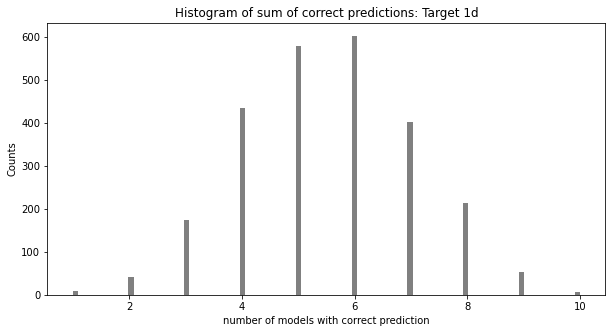

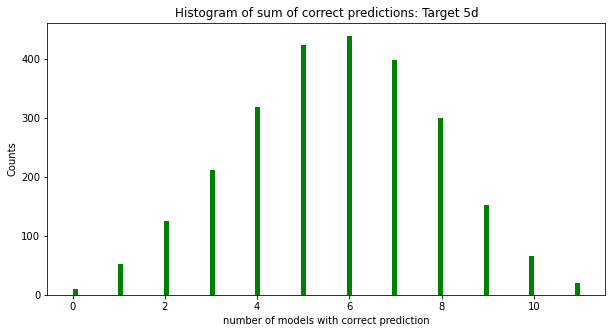

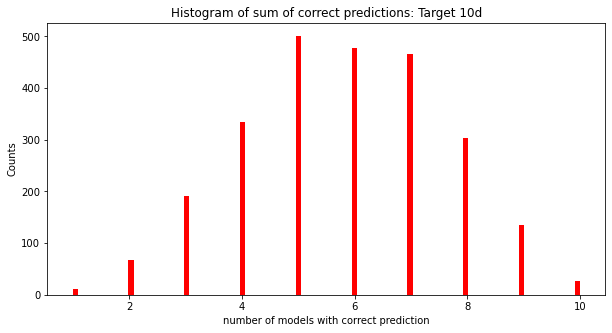

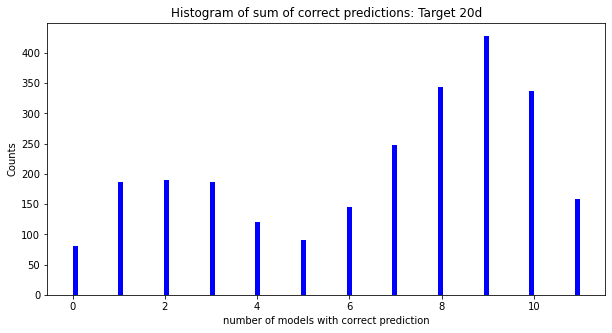

In [15]:
# Plot histogram of sum of correct predictions from multi-run experiment with n_runs
# seperately for different target horizons:

target_horizons_text = ["1d", "5d", "10d", "20d"]
colors = ["grey", "green", "red", "blue"]

# Loop over target horizons:
for t in range(len(target_horizons_text)):
    nBins = 100
    fig, axes = plt.subplots(1, 1, figsize=(10,5))
    axes.hist(sum_val_correct_pred[t,:], nBins, color=colors[t])
    axes.set_xlabel("number of models with correct prediction")
    axes.set_ylabel("Counts")
    axes.set_title("Histogram of sum of correct predictions: Target " + target_horizons_text[t])
    plt.show()

### Interim discussion: Number of models with correct prediction

For target horizons 1d / 5d / 10d we find some Gaussian distribution of number of models with correct prediction, somewhat centered arround 5 of 6, so quite in the middle, when we have *n_runs = 11*.

Only for **target 20d** we find a different histogram showing *two* seperate distributions: This gives already a hint that there are samples on which most of the models agree with their prediction. That is the basis for finding a **partition of high / low reliability** samples on the time line.

In [16]:
## Get min/max from absolute closing prices for SP500 and VIX for train, val and test data.
## Convert to constant lines for plotting later on: Need min / max lines as limits.

# SP500
train_close_abs_min = np.min(train_close_abs) * np.ones(len(train_close_abs))
train_close_abs_max = np.max(train_close_abs) * np.ones(len(train_close_abs))
val_close_abs_min = np.min(val_close_abs) * np.ones(len(val_close_abs))
val_close_abs_max = np.max(val_close_abs) * np.ones(len(val_close_abs))
test_close_abs_min = np.min(test_close_abs) * np.ones(len(test_close_abs))
test_close_abs_max = np.max(test_close_abs) * np.ones(len(test_close_abs))

# VIX
vix_train_close_abs_min = np.min(vix_train_close_abs) * np.ones(len(vix_train_close_abs))
vix_train_close_abs_max = np.max(train_close_abs) * np.ones(len(vix_train_close_abs))
vix_val_close_abs_min = np.min(vix_val_close_abs) * np.ones(len(vix_val_close_abs))
vix_val_close_abs_max = np.max(vix_val_close_abs) * np.ones(len(vix_val_close_abs))
vix_test_close_abs_min = np.min(vix_test_close_abs) * np.ones(len(vix_test_close_abs))
vix_test_close_abs_max = np.max(vix_test_close_abs) * np.ones(len(vix_test_close_abs))

Text(0.5, 0, 'time step')

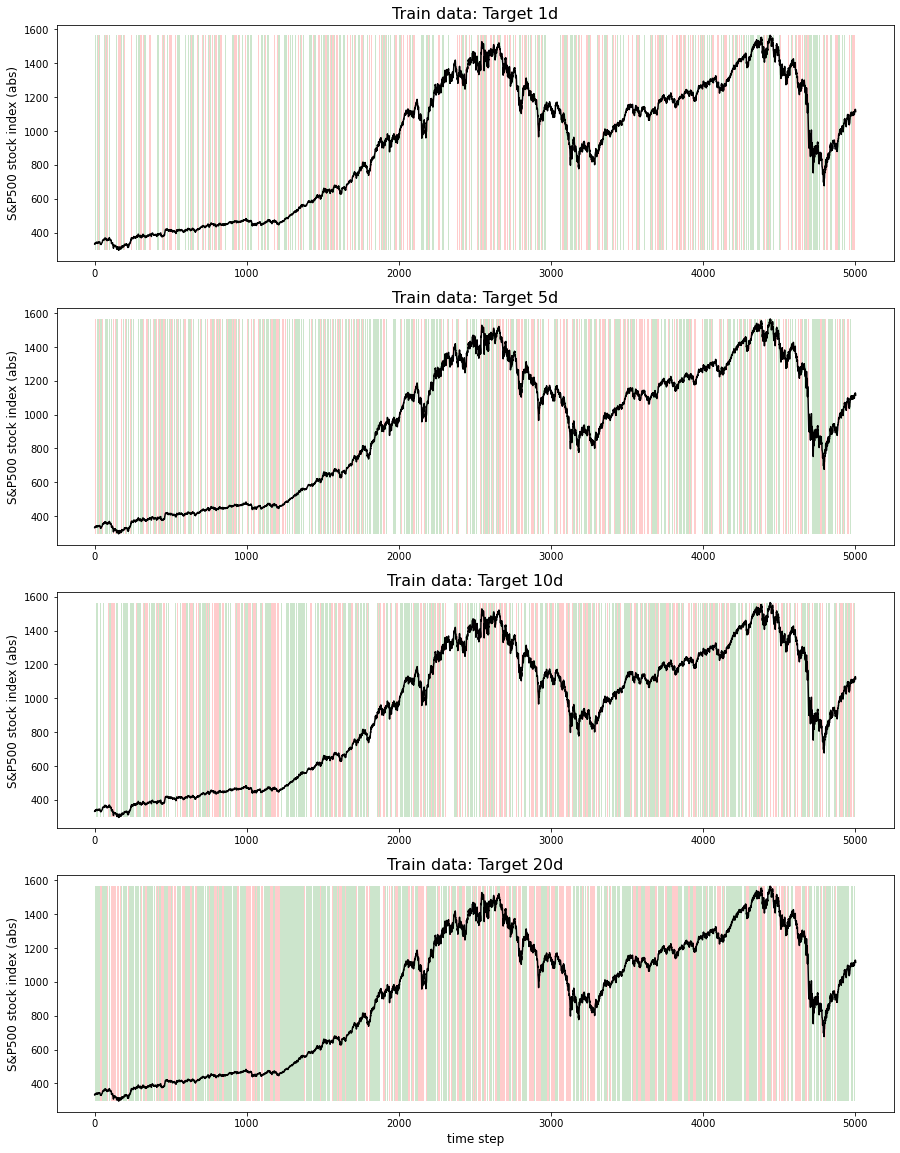

In [92]:
## Plot areas with high / low reliability from multirun experiment:
## Where does the majority of models meet true (green) target or fail (red)?

## NOTE: We did this experiment with fixed input_length = 20d. Therefore need to cut the first 20 steps from 
##       train_close_abs and the last 20 steps from predictions, to adjust time line.

## AND NOTE: We find white areas whenever true and false predictions alternate from step to step.
##           Shaded areas need at least two subsequent true or false predictions.
##           Could alter the plot by setting option "interpolate = True" in fill_between.

# Train data:
fig, axes = plt.subplots(4, 1, figsize=(15,20))

# Loop over target horizons:
for i in range(len(target_horizons)):
    axes[i].plot(train_close_abs[20:], color = 'black', label = 'val close (abs)')
    axes[i].set_ylabel("S&P500 stock index (abs)", fontsize=12)
    axes[i].set_title("Train data: Target " + target_horizons_text[i], fontsize=16)

    # Shade area highlighting distinct periods.
    axes[i].fill_between(range(len(train_close_abs[20:])),train_close_abs_min[:-20], train_close_abs_max[:-20], 
                         where = (sum_train_correct_pred[i,:-20] >= 6), facecolor='green', alpha=0.2)
    axes[i].fill_between(range(len(train_close_abs[20:])),train_close_abs_min[:-20], train_close_abs_max[:-20], 
                         where = (sum_train_correct_pred[i,:-20] < 6), facecolor='red', alpha=0.2)
    
axes[3].set_xlabel("time step", fontsize=12)

Text(0.5, 0, 'time step')

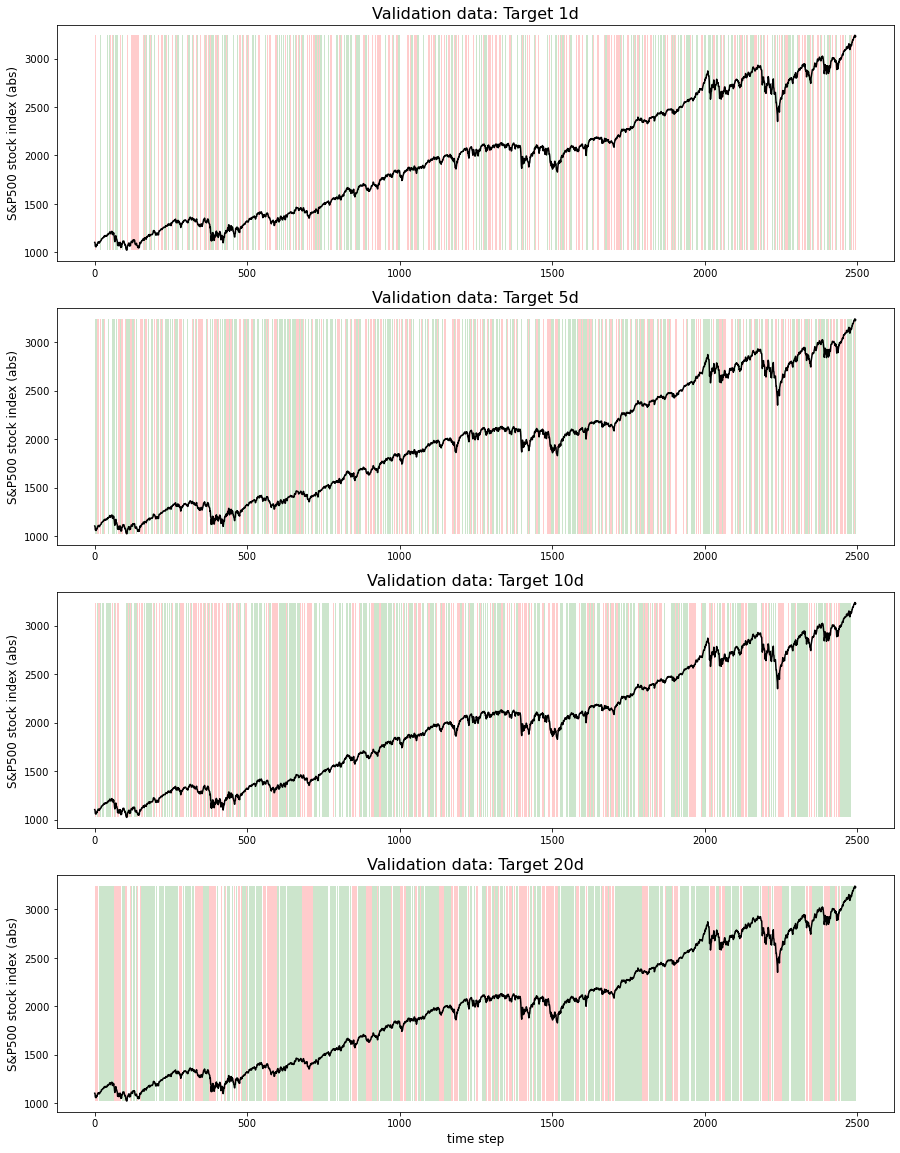

In [18]:
# Validation data:
fig, axes = plt.subplots(4, 1, figsize=(15,20))

# Loop over target horizons:
for i in range(len(target_horizons)):
    axes[i].plot(val_close_abs[20:], color = 'black', label = 'val close (abs)')
    axes[i].set_ylabel("S&P500 stock index (abs)", fontsize=12)
    axes[i].set_title("Validation data: Target " + target_horizons_text[i], fontsize=16)

    # Shade area highlighting distinct periods.
    axes[i].fill_between(range(len(val_close_abs[20:])),val_close_abs_min[:-20], val_close_abs_max[:-20], 
                         where = (sum_val_correct_pred[i,:-20] >= 6), facecolor='green', alpha=0.2)
    axes[i].fill_between(range(len(val_close_abs[20:])),val_close_abs_min[:-20], val_close_abs_max[:-20], 
                         where = (sum_val_correct_pred[i,:-20] < 6), facecolor='red', alpha=0.2)
    
axes[3].set_xlabel("time step", fontsize=12)

Text(0.5, 0, 'time step')

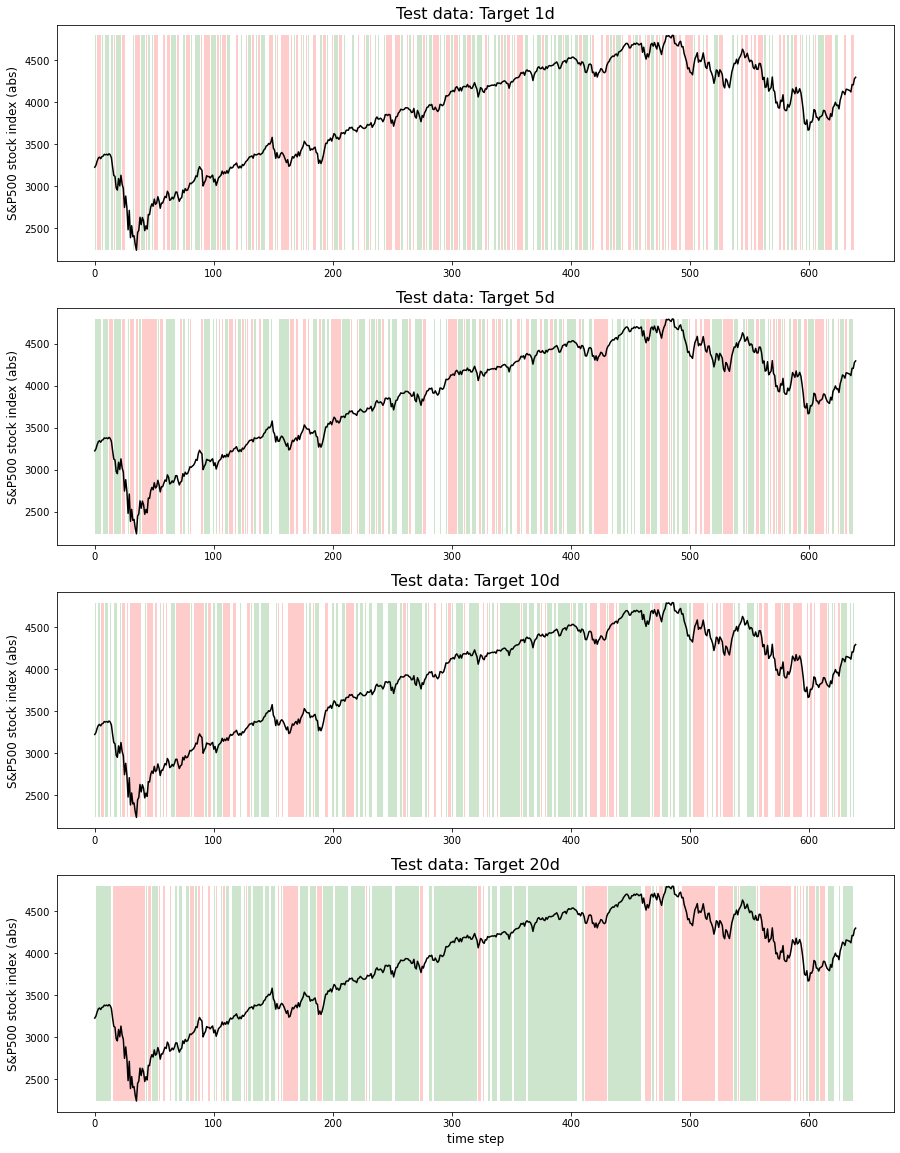

In [19]:
# Test data:
fig, axes = plt.subplots(4, 1, figsize=(15,20))

# Loop over target horizons:
for i in range(len(target_horizons)):
    axes[i].plot(test_close_abs[20:], color = 'black', label = 'val close (abs)')
    axes[i].set_ylabel("S&P500 stock index (abs)", fontsize=12)
    axes[i].set_title("Test data: Target " + target_horizons_text[i], fontsize=16)

    # Shade area highlighting distinct periods.
    axes[i].fill_between(range(len(test_close_abs[20:])),test_close_abs_min[:-20], test_close_abs_max[:-20], 
                         where = (sum_test_correct_pred[i,:-20] >= 6), facecolor='green', alpha=0.2)
    axes[i].fill_between(range(len(test_close_abs[20:])),test_close_abs_min[:-20], test_close_abs_max[:-20], 
                         where = (sum_test_correct_pred[i,:-20] < 6), facecolor='red', alpha=0.2)
    
axes[3].set_xlabel("time step", fontsize=12)

Text(0.5, 0, 'time step')

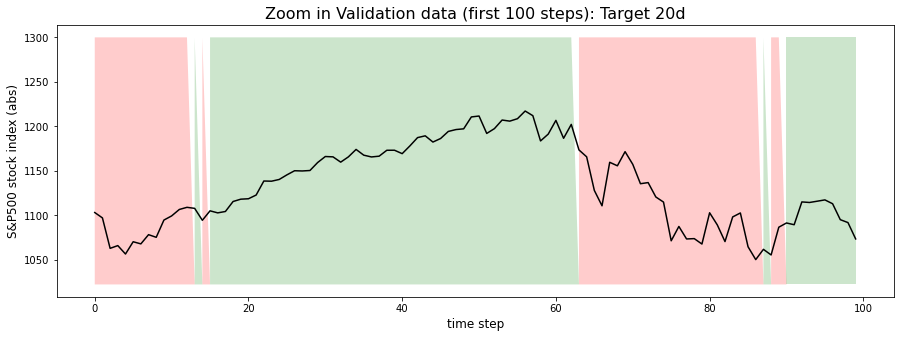

In [20]:
# Validation data:
fig, axes = plt.subplots(1, 1, figsize=(15,5))

# Loop over target horizons:
axes.plot(val_close_abs[20:120], color = 'black', label = 'val close (abs)')
axes.set_ylabel("S&P500 stock index (abs)", fontsize=12)
axes.set_title("Zoom in Validation data (first 100 steps): Target " + target_horizons_text[3], fontsize=16)

# Shade area highlighting distinct periods.
axes.fill_between(range(len(val_close_abs[:100])),val_close_abs_min[:100], 1300, 
                     where = (sum_val_correct_pred[3,:100] >= 6), facecolor='green', alpha=0.2, interpolate=True)
axes.fill_between(range(len(val_close_abs[:100])),val_close_abs_min[:100], 1300, 
                     where = (sum_val_correct_pred[3,:100] < 6), facecolor='red', alpha=0.2, interpolate=True)

axes.set_xlabel("time step", fontsize=12)

In [21]:
## Plot areas with high / low reliability from multirun experiment:
## Where does the majority of models meet true (green) target or fail (red)?

## NOTE: We did this experiment with fixed input_length = 20d. Therefore need to cut the first 20 steps from 
##       vix_train_close_abs and the last 20 steps from predictions, to adjust time line.

## AND NOTE: We find white areas whenever true and false predictions alternate from step to step.
##           Shaded areas need at least two subsequent true or false predictions.
##           Could alter the plot by setting option "interpolate = True" in fill_between.

Text(0.5, 0, 'time step')

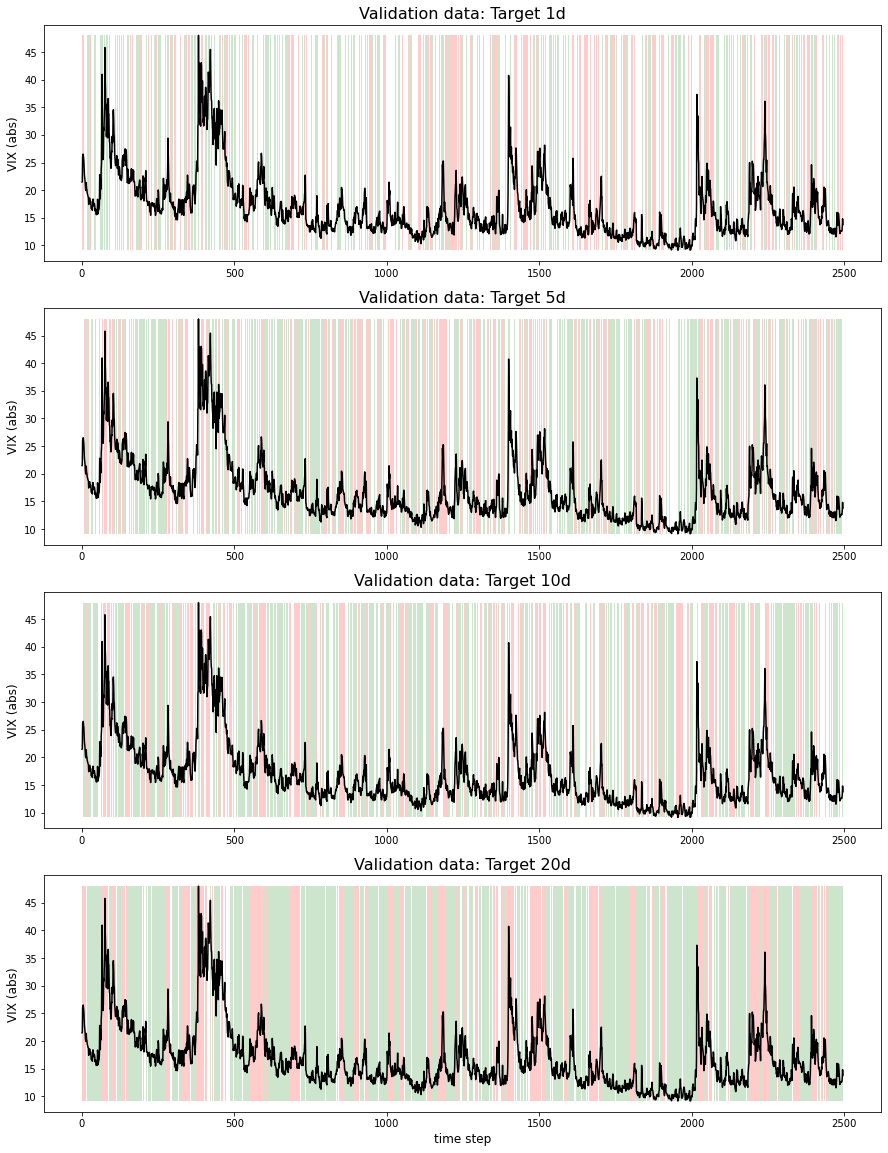

In [22]:
# Validation data:
fig, axes = plt.subplots(4, 1, figsize=(15,20))

# Loop over target horizons:
for i in range(len(target_horizons)):
    axes[i].plot(vix_val_close_abs[20:], color = 'black', label = 'VIX - val close (abs)')
    axes[i].set_ylabel("VIX (abs)", fontsize=12)
    axes[i].set_title("Validation data: Target " + target_horizons_text[i], fontsize=16)

    # Shade area highlighting distinct periods.
    axes[i].fill_between(range(len(vix_val_close_abs[20:])),vix_val_close_abs_min[:-20], vix_val_close_abs_max[:-20], 
                         where = (sum_val_correct_pred[i,:-20] >= 6), facecolor='green', alpha=0.2)
    axes[i].fill_between(range(len(vix_val_close_abs[20:])),vix_val_close_abs_min[:-20], vix_val_close_abs_max[:-20], 
                         where = (sum_val_correct_pred[i,:-20] < 6), facecolor='red', alpha=0.2)
    
axes[3].set_xlabel("time step", fontsize=12)

Text(0.5, 0, 'time step')

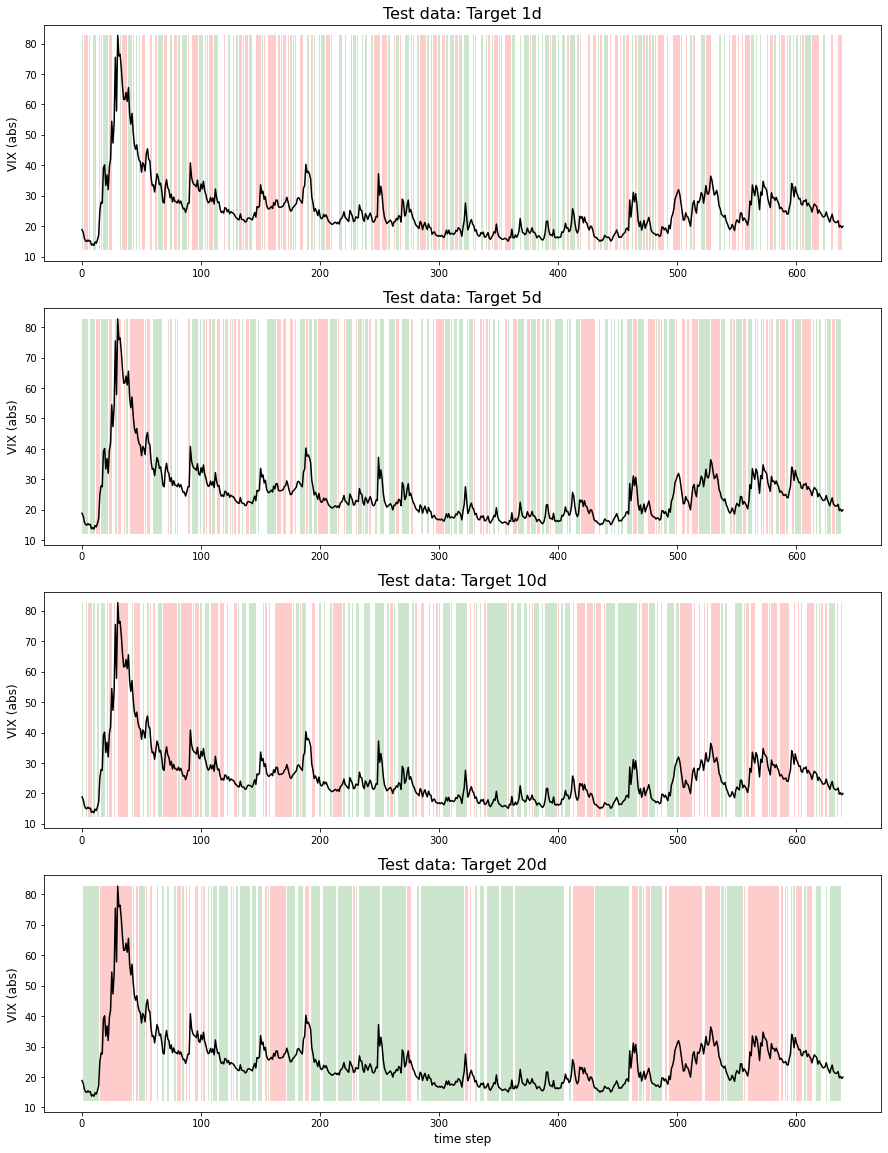

In [23]:
# Test data:
fig, axes = plt.subplots(4, 1, figsize=(15,20))

# Loop over target horizons:
for i in range(len(target_horizons)):
    axes[i].plot(vix_test_close_abs[20:], color = 'black', label = 'VIX - close (abs)')
    axes[i].set_ylabel("VIX (abs)", fontsize=12)
    axes[i].set_title("Test data: Target " + target_horizons_text[i], fontsize=16)

    # Shade area highlighting distinct periods.
    axes[i].fill_between(range(len(vix_test_close_abs[20:])),vix_test_close_abs_min[:-20], vix_test_close_abs_max[:-20], 
                         where = (sum_test_correct_pred[i,:-20] >= 6), facecolor='green', alpha=0.2)
    axes[i].fill_between(range(len(vix_test_close_abs[20:])),vix_test_close_abs_min[:-20], vix_test_close_abs_max[:-20], 
                         where = (sum_test_correct_pred[i,:-20] < 6), facecolor='red', alpha=0.2)
    
axes[3].set_xlabel("time step", fontsize=12)

Text(0.5, 0, 'time step')

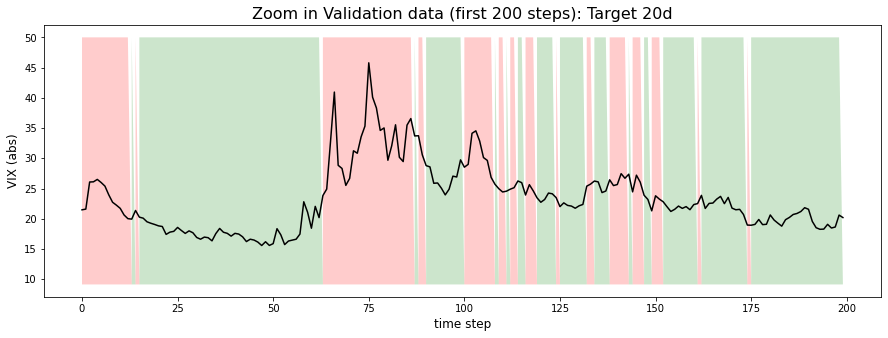

In [24]:
# Validation data:
fig, axes = plt.subplots(1, 1, figsize=(15,5))

# Loop over target horizons:
axes.plot(vix_val_close_abs[20:220], color = 'black', label = 'VIX close (abs)')
axes.set_ylabel("VIX (abs)", fontsize=12)
axes.set_title("Zoom in Validation data (first 200 steps): Target " + target_horizons_text[3], fontsize=16)

# Shade area highlighting distinct periods.
axes.fill_between(range(len(vix_val_close_abs[:200])),vix_val_close_abs_min[:200], 50, 
                     where = (sum_val_correct_pred[3,:200] >= 6), facecolor='green', alpha=0.2, interpolate=True)
axes.fill_between(range(len(vix_val_close_abs[:200])),vix_val_close_abs_min[:200], 50, 
                     where = (sum_val_correct_pred[3,:200] < 6), facecolor='red', alpha=0.2, interpolate=True)

axes.set_xlabel("time step", fontsize=12)

### Discussion on repeated multirun experiment: Finding high / low reliability regimes

We indeed find connected areas of high / low reliability - at least for **target = 20d**. On the first sight it looks like the models tend to fail whenever things get rough and stocks either crash or heavily fluctuate, as expressed in **high or rising volatility (VIX)**.

So we find a **partitioning** of the whole time line.

If this holds true, the task could be altered or extended to train a separate model that should find **tipping points** or **regime shifts**.

### Third multirun experiment: Train model to predict  high / low reliability areas on continuous (discrete) target

In *notebook 02* we tried to train a model on regular scaled inputs (SP500 close rel. chg.) and used the number of correct predictions as binary target - and failed.

We now want to take the sum of correct predictions from second multirun experiment **as continuous target** (with discrete values).

Here we try to **train a model on VIX (close rel. chg.)** instead and still use the number of correct predictions as **continuous target** with discrete values.

Since we found best connected areas for **target length 20d** by visual inspection, stick to that for now.
And as we trained our multi-run models with samples of **input length 20d**, we also try to use the same input length **for VIX (close rel. chg.) input samples**.

In [17]:
## Prepare targets:
# Focus on target = 20d.
# Take sum of correct predictions from second multirun experiment as continuous target (with discrete values).
# Reshape to have dimensions (samples, 1).
train_target_true_pred = sum_train_correct_pred[3,:].reshape((len(sum_train_correct_pred[3,:]), 1))
val_target_true_pred = sum_val_correct_pred[3,:].reshape((len(sum_val_correct_pred[3,:]), 1))
test_target_true_pred = sum_test_correct_pred[3,:].reshape((len(sum_test_correct_pred[3,:]), 1))

In [18]:
## Prepare BINARY targets:
# Focus on target = 20d.
# Check, where majority of model runs produced CORRECT prediction (bin target=1) or FAILED (bin target=0).
# Reshape to have dimensions (samples, 1).
train_target_true_pred_bin = (sum_train_correct_pred[3,:] >= 6).astype(int).reshape((len(sum_train_correct_pred[3,:]), 1))
val_target_true_pred_bin = (sum_val_correct_pred[3,:] >= 6).astype(int).reshape((len(sum_val_correct_pred[3,:]), 1))
test_target_true_pred_bin = (sum_test_correct_pred[3,:] >= 6).astype(int).reshape((len(sum_test_correct_pred[3,:]), 1))

In [19]:
## Set parameters:

# Number of runs for each setting:
n_runs = 11

# Fixed model parameters:
weight_init = tfi.glorot_uniform() # Taken as default.
bias_init = tfi.Zeros() # Taken as default.
CNN_filters = [10,20]
CNN_kernel_sizes = [5,5]
fc_units = [20,10]
n_epochs = 15
batch_size = 20
learning_rate = 0.0001
loss_function = 'mse'

# Parameters to be chosen for pre-processing:
input_features = (1,) # 0: SP500 close (rel. chg.), 1: VIX close (rel. chg.)
input_length = 20

In [20]:
## Pre-process inputs and targets for target horizon 20d.

# Select specified input features:
inputs_selected = inputs[:,input_features]

# Select target horizon:
target_selected = targets[:, (3,)]

# Split input values into sequences of specified input length:
inputs_split = split_sequence(inputs_selected, input_length)

# Adjust data, year and targets: Cut first (input_length - 1) entries
data_cut = data[input_length-1:]
year_cut = year[input_length-1:]
target_cut = target_selected[input_length-1:]

## Split inputs and targets into train / validation / test sets, according to year:

# Train data: 1985 .. 2009
# Val data:   2010 .. 2019
# Test data:  2020 .. end

train_input = inputs_split[year_cut <= 2009]
val_input = inputs_split[(year_cut >= 2010) & (year_cut < 2020)]
test_input = inputs_split[year_cut >= 2020]

train_target = target_cut[year_cut <= 2009]
val_target = target_cut[(year_cut >= 2010) & (year_cut < 2020)]
test_target = target_cut[year_cut >= 2020]

# Convert to binary targets (up = 1, down = 0):
train_target_bin = train_target>0
val_target_bin = val_target>0
test_target_bin = test_target>0

# Get min and max for ALL input features from TRAIN data:
train_min = np.min(train_input, axis=(0,1))
train_max = np.max(train_input, axis=(0,1))

# Apply min max scaling to train / val / test inputs: Substract min and divide by (max - min)
train_input_scaled = (train_input - train_min) / (train_max - train_min)
val_input_scaled = (val_input - train_min) / (train_max - train_min)
test_input_scaled = (test_input - train_min) / (train_max - train_min)

In [27]:
# Initialize storage for predictions and correct predictions for target = 20d
# Desired shape: (#runs, #samples)

# NOTE: Need to be careful not to over-write above results from first multi-run experiment!
# Add prefix "high_low".
high_low_train_pred_all = np.zeros((n_runs, len(train_target)))
high_low_val_pred_all = np.zeros((n_runs, len(val_target)))
high_low_test_pred_all = np.zeros((n_runs, len(test_target)))
high_low_train_correct_pred = np.zeros((n_runs, len(train_target)))
high_low_val_correct_pred = np.zeros((n_runs, len(val_target)))
high_low_test_correct_pred = np.zeros((n_runs, len(test_target)))

In [30]:
# Loop over number of runs:
for n_run in range(n_runs):

    # Print status:
    print("Run: ", n_run+1, " of ", n_runs)

    # Set up compiled model: Want to have 'linear' activation in all fc layers.
    # Work with continuous (discrete) targets. Use regular scaled inputs (close rel chg) with input length 20d.

    # Start model definition:
    model = Sequential()

    # Add input layer:
    input_shape = (input_length, len(input_features))
    model.add(Input(shape=input_shape))

    # Add CNN layer(s):
    for i in range(len(CNN_filters)):
        model.add(Conv1D(filters=CNN_filters[i], kernel_size=CNN_kernel_sizes[i], strides=1,
                         kernel_initializer=weight_init, bias_initializer = bias_init))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.3))

        # Add max pooling, if input_length is equal or above 40d to limit number of trainable parameters:
        if input_length >= 40:
            model.add(MaxPooling1D(pool_size=2))

    # Flatten CNN output:
    model.add(Flatten())

    # Add hidden fc layer(s):
    for i in range(len(fc_units)):
        model.add(Dense(units=fc_units[i], activation = 'linear',
                        kernel_initializer=weight_init, bias_initializer = bias_init))

    # Add output unit:
    model.add(Dense(units=1, name = "output", activation = 'linear',
                    kernel_initializer=weight_init, bias_initializer = bias_init))

    # Compile model with desired loss function:
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=loss_function)

    # Train model on scaled inputs and un-scaled synthetic targets:
    history = model.fit(
        train_input_scaled, train_target_true_pred,
        epochs=n_epochs, batch_size=batch_size, 
        shuffle=True, verbose=0, 
        validation_data=(val_input_scaled, val_target_true_pred)
    )

    # Get model predictions:
    train_pred = model.predict(train_input_scaled)
    val_pred = model.predict(val_input_scaled)
    test_pred = model.predict(test_input_scaled)

    # Convert to binary predictions:
    # Defined from second multirun experiment "high reliability" when 6 or more 
    # models (from 11 runs in total) agreed:
    train_pred_bin = (train_pred >= 6)
    val_pred_bin = (val_pred >= 6)
    test_pred_bin = (test_pred >= 6)

    # Store model predictions on train, validation and test data
    high_low_train_pred_all[n_run,:] = train_pred[:,0]
    high_low_val_pred_all[n_run,:] = val_pred[:,0]
    high_low_test_pred_all[n_run,:] = test_pred[:,0]  

    # Store for current run where binary predictions on train, validation and test data meet binary targets:
    high_low_train_correct_pred[n_run,:] = ((train_pred_bin == train_target_true_pred_bin).astype(int)[:,0])
    high_low_val_correct_pred[n_run,:] = (val_pred_bin == val_target_true_pred_bin).astype(int)[:,0]
    high_low_test_correct_pred[n_run,:] = (test_pred_bin == test_target_true_pred_bin).astype(int)[:,0]

Run:  1  of  11
Run:  2  of  11
Run:  3  of  11
Run:  4  of  11
Run:  5  of  11
Run:  6  of  11
Run:  7  of  11
Run:  8  of  11
Run:  9  of  11
Run:  10  of  11
Run:  11  of  11


In [21]:
### Save and reload histories:

## Very good first run, but unfortunatelly only saved correct_pred, NOT pred_all

# np.save('../results/histories_multirun_04a.npy', high_low_train_correct_pred)
# np.save('../results/histories_multirun_04b.npy', high_low_val_correct_pred)
# np.save('../results/histories_multirun_04c.npy', high_low_test_correct_pred)

# high_low_train_correct_pred = np.load('../results/histories_multirun_04a.npy')
# high_low_val_correct_pred = np.load('../results/histories_multirun_04b.npy')
# high_low_test_correct_pred = np.load('../results/histories_multirun_04c.npy')

## Another outstanding (and yet reproducible!) run, this time also saved pred_all

# np.save('../results/histories_multirun_06a.npy', high_low_train_correct_pred)
# np.save('../results/histories_multirun_06b.npy', high_low_val_correct_pred)
# np.save('../results/histories_multirun_06c.npy', high_low_test_correct_pred)
# np.save('../results/histories_multirun_06d.npy', high_low_train_pred_all)
# np.save('../results/histories_multirun_06e.npy', high_low_val_pred_all)
# np.save('../results/histories_multirun_06f.npy', high_low_test_pred_all)

# high_low_train_correct_pred = np.load('../results/histories_multirun_06a.npy')
# high_low_val_correct_pred = np.load('../results/histories_multirun_06b.npy')
# high_low_test_correct_pred = np.load('../results/histories_multirun_06c.npy')
# high_low_train_pred_all = np.load('../results/histories_multirun_06d.npy')
# high_low_val_pred_all = np.load('../results/histories_multirun_06e.npy')
# high_low_test_pred_all = np.load('../results/histories_multirun_06f.npy')


## Additional parameters to restore plots subsequent steps from re-loaded data:
# target_horizons = [(3,),] # 0: 1d, 1: 5d, 2: 10d, 3: 20d
# input_length = 20
# n_epochs = 15
# batch_size = 20

In [24]:
## Derive a binary prediction to classify VIX samples a HIGH / LOW reliable, according to predicted number 
# of correct predictions. HIGH: Prediction is greater or equal to 6, LOW: else.
# Note: This actually tells us, WHERE we act, according to binary ensemble predictor UP or DOWN.
# Count number of models that predicted HIGH reliability (>=5.5).
# Get majority vote: More or equal than 6 models predicting HIGH reliability, we take HIGH as ensemble prediction.
# Create binary target HIGH = 1, LOW = 0:
high_low_ensemble_train_pred_bin = (np.sum((high_low_train_pred_all >= 5.5), axis=0) >= 6).astype(int)
high_low_ensemble_val_pred_bin = (np.sum((high_low_val_pred_all >= 5.5), axis=0) >= 6).astype(int)
high_low_ensemble_test_pred_bin = (np.sum((high_low_test_pred_all >= 5.5), axis=0) >= 6).astype(int)

In [26]:
# Get accuracy of multi-run experiment ensemble prediction:
print("train acc from multi-run experiment: ", np.round(
    sum(high_low_ensemble_train_pred_bin == train_target_true_pred_bin[:,0])
    / len(train_target_true_pred_bin),3)
)
print("val acc from multi-run experiment: ", np.round(
    sum(high_low_ensemble_val_pred_bin == val_target_true_pred_bin[:,0])
    / len(val_target_true_pred_bin),3)
)
print("test acc from multi-run experiment: ", np.round(
    sum(high_low_ensemble_test_pred_bin == test_target_true_pred_bin[:,0])
    / len(test_target_true_pred_bin),3)
)

# Compare to naive accuracy, if we predict ALL areas to be "high reliability"
print("\nnaive train acc: ", np.round(sum(train_target_true_pred_bin)/len(train_target_true_pred_bin),3)[0])
print("naive val acc: ", np.round(sum(val_target_true_pred_bin)/len(val_target_true_pred_bin),3)[0])
print("naive test acc: ", np.round(sum(test_target_true_pred_bin)/len(test_target_true_pred_bin),3)[0])

train acc from multi-run experiment:  0.622
val acc from multi-run experiment:  0.655
test acc from multi-run experiment:  0.594

naive train acc:  0.618
naive val acc:  0.66
naive test acc:  0.603


### Discussion on multi-run experiments

#### CNN/fc model: Multi-run experiment to lable high/low reliability sectors

Fix base parameters as follows:

- weight_init = tfi.glorot_uniform()
- bias_init = tfi.Zeros()
- CNN_filters = [10,20]
- CNN_kernel_sizes = [5,5]
- fc_units = [20,10]
- n_epochs = 20
- batch_size = 10
- learning_rate = 0.0001
- loss_function = 'mse'

Performed multi-run experiment with **n_runs = 11** (to have an uneven number!). Assumed **optimal input length** to be **20d**. Did the experiment **for all target length** 1d/5d/10d/20d seperately. Used **close_rel_chg** as **only input feature** and regular **mse loss**.

**SAVED RESULTS:** Where binary predictions on train, validation and test data meet binary targets

- histories_multirun_06a.npy --> train_correct_pred
- histories_multirun_06b.npy --> val_correct_pred
- histories_multirun_06c.npy --> test_correct_pred
- histories_multirun_06d.npy --> train_pred_all
- histories_multirun_06e.npy --> val_pred_all
- histories_multirun_06f.npy --> test_pred_all

We indeed find connected areas of high / low reliability - at least for **target = 10d** and **20d** even better. On the first sight it looks like the models tend to fail whenever things get rough and stocks either crash or heavily fluctuate.

####  Train model to predict  high / low reliability areas

In *notebook 02* we tried to train a model on regular scaled inputs (SP500 close rel. chg.) and used the number of correct predictions as binary target - and failed.

We then took the sum of correct predictions from above mentioned multirun experiment **as continuous target** (with discrete values).

And **trained a model on VIX (close rel. chg.)** as only input feature.

Since we found best connected areas for **target length 20d** by visual inspection, stick to that for now.
And as we trained our multi-run models with samples of **input length 20d**, we also used the same input length **for VIX (close rel. chg.) input samples**.

**SAVED RESULTS:** Where binary predictions on train, validation and test data meet binary targets

- histories_multirun_04a.npy --> train_correct_pred
- histories_multirun_04b.npy --> val_correct_pred
- histories_multirun_04c.npy --> test_correct_pred

### Results

Given the above multi-run experiment to label samples as "high / low reliability" as binary target, we can compute naive accuracies: If we predicted all samples to have "high reliabily", we find 61 / 65 / 62.7% accuracy on train / val / test samples.

If we then train a model to predict "high / low reliability" on VIX (rel chg) as input, accuracy is found to be significantly higher and reads 75.3 / 71.5 / 73.3% on treain / val / test samples.

All results are reproducible!

### Final check:

Does that lead to a significant outperformance? Then we are done!

In [120]:
# Get majority vote on identifying high/low reliability samples as binary ensemble predictor:
high_low_train_correct_pred_bin = (np.sum(high_low_train_correct_pred, axis=0)>=6).astype(int)
high_low_val_correct_pred_bin = (np.sum(high_low_val_correct_pred, axis=0)>=6).astype(int)
high_low_test_correct_pred_bin = (np.sum(high_low_test_correct_pred, axis=0)>=6).astype(int)

In [121]:
# Get "naive" performance, when - for simplicity - we just add target performance (20d horizon):
print("naive train performance: ", np.round(sum(train_target[:,0])*100,1), "%")
print("naive val performance: ", np.round(sum(val_target[:,0])*100,1), "%")
print("naive test performance: ", np.round(sum(test_target[:,0])*100,1), "%")

naive train performance:  2974.4 %
naive val performance:  2311.2 %
naive test performance:  576.7 %


In [27]:
# Get model performance, we only act on high reliability samples and then ALWAYS get LONG:
print("train performance: ", np.round(sum(high_low_ensemble_train_pred_bin*train_target[:,0])*100,1), "%")
print("val performance: ", np.round(sum(high_low_ensemble_val_pred_bin*val_target[:,0])*100,1), "%")
print("test performance: ", np.round(sum(high_low_ensemble_test_pred_bin*test_target[:,0])*100,1), "%")

train performance:  3167.3 %
val performance:  2294.2 %
test performance:  580.4 %


### Discussion on performance

If we invest every day and stay long for 20d, then total performance can be - for simplicity - computed as sum of target values (SP500 close rel. chg. with 20d horizon).

Compared to that, if we follow our model's recommendation and always go LONG if sample is classified as HIGH reliable, this leads to **no significant outperformance** on train / val / test data.

#### Practical Issues

- So we need to train and store 11 models on VIX close (rel. chg.) samples with 20d input length.
- Then feed models with current sample and act if majority of models labels sample as "high reliable".

#### Pipline for further research:

- Can we also succeed on shorter target horizons? 10d / 5d / 1d? Or is is only stable for longer targets (20d)?
- Try to optimize model to predict high / low reliability samples by adding additional features.
- Can we trust the majority vote from first multi-run experiment more, when vote is UP (--> "True positive") compared to DOWN (--> "True negative")?

In [ ]:
# Plot SP500 abs with binary ensemble predictor shaded grey (=1) to highlight phases, where we would act since
# model tells us, that given sample points to high reliability:

Text(0.5, 0, 'time step')

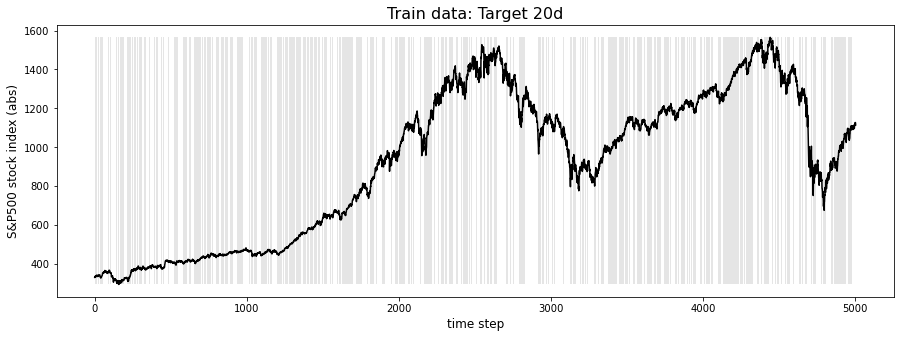

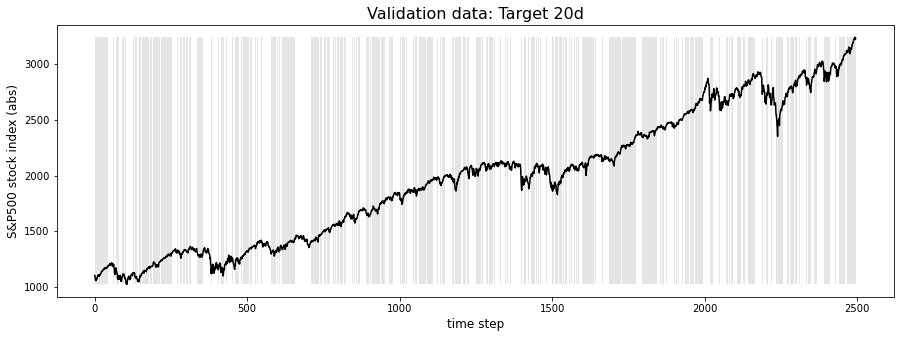

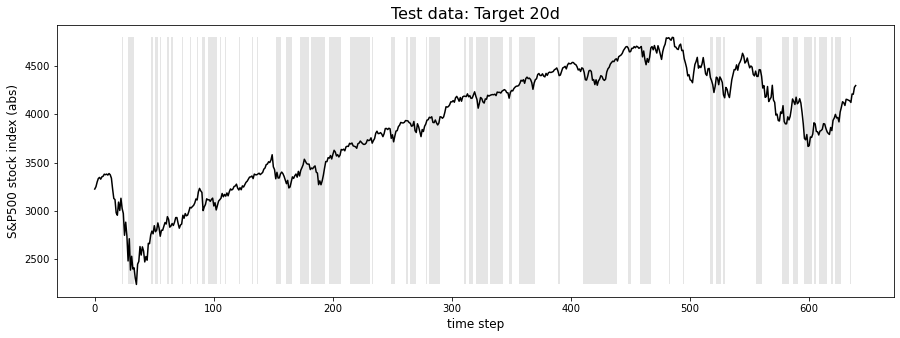

In [63]:
## Plot areas with high reliability from multirun experiment:
## Where does the majority of models recommend us to act (grey)?

## NOTE: We did this experiment with fixed input_length = 20d. Therefore need to cut the first 20 steps from 
##       train_close_abs and the last 20 steps from predictions, to adjust time line.

## AND NOTE: We find white areas whenever true and false predictions alternate from step to step.
##           Shaded areas need at least two subsequent true or false predictions.
##           Could alter the plot by setting option "interpolate = True" in fill_between.

# Train data:
fig, axes = plt.subplots(1, 1, figsize=(15,5))

axes.plot(train_close_abs[20:], color = 'black', label = 'train close (abs)')
axes.set_ylabel("S&P500 stock index (abs)", fontsize=12)
axes.set_title("Train data: Target 20d", fontsize=16)

# Shade area highlighting distinct periods.
axes.fill_between(range(len(train_close_abs[20:])),train_close_abs_min[:-20], train_close_abs_max[:-20], 
                     where = (train_pred_bin[20:] == 1), facecolor='grey', alpha=0.2)
    
axes.set_xlabel("time step", fontsize=12)


# Val data:
fig, axes = plt.subplots(1, 1, figsize=(15,5))

axes.plot(val_close_abs[20:], color = 'black', label = 'val close (abs)')
axes.set_ylabel("S&P500 stock index (abs)", fontsize=12)
axes.set_title("Validation data: Target 20d", fontsize=16)

# Shade area highlighting distinct periods.
axes.fill_between(range(len(val_close_abs[20:])),val_close_abs_min[:-20], val_close_abs_max[:-20], 
                     where = (val_pred_bin[20:] == 1), facecolor='grey', alpha=0.2)
    
axes.set_xlabel("time step", fontsize=12)


# Test data:
fig, axes = plt.subplots(1, 1, figsize=(15,5))

axes.plot(test_close_abs[20:], color = 'black', label = 'val close (abs)')
axes.set_ylabel("S&P500 stock index (abs)", fontsize=12)
axes.set_title("Test data: Target 20d", fontsize=16)

# Shade area highlighting distinct periods.
axes.fill_between(range(len(test_close_abs[20:])),test_close_abs_min[:-20], test_close_abs_max[:-20], 
                     where = (test_pred_bin[20:] == 1), facecolor='grey', alpha=0.2)
    
axes.set_xlabel("time step", fontsize=12)



### Extension: Whole model's Outperformance?!

In the first multi-run experiment we trained *n_runs = 11* models on **continuous SP500 close (rel. chg.)** with samples of *input_length = 20d* on **continuous SP500 close (rel. chg.)** target with *target_horizon = 20d*.

We then identified **high / low reliability** samples by looking at how many of the *n_runs = 11* models came to the **correct prediction** in terms of correctly prediction **UP / DOWN** movement (binary). And if at least 6 models agree, we label a spot high reliable.

But to compute the overall outperformance, we need to know, what the majority vote was, regardless of being  correct.

Then check from the high reliability samples: How many of these come with an ensemble prediction UP and DOWN?
Are phases with calm UP movement of high reliability? Or in other words: Does the model tell us to stay out
whenever things get rough?

In [32]:
# Focus on target 20d.
# Count number of models that predicted an UP movement (>0).
# Get majority vote: More or equal to 6 models predicting UP movement, we take UP as ensemble prediction.
# Create binary target UP = 1, DOWN = 0:
ensemble_train_pred_bin_20d = (np.sum((train_pred_all > 0), axis=1) >= 6)[3].astype(int)
ensemble_val_pred_bin_20d = (np.sum((val_pred_all > 0), axis=1) >= 6)[3].astype(int)
ensemble_test_pred_bin_20d = (np.sum((test_pred_all > 0), axis=1) >= 6)[3].astype(int)

In [33]:
# Now check from the high reliability samples: How many of these come with an ensemble prediction UP and DOWN?
print("rel. amount of TRAIN samples with ensemble prediction UP: ", 
      np.round(sum(ensemble_train_pred_bin_20d)/len(ensemble_train_pred_bin_20d),3))
print("rel. amount of VAL samples with ensemble prediction UP: ", 
      np.round(sum(ensemble_val_pred_bin_20d)/len(ensemble_val_pred_bin_20d),3))
print("rel. amount of TEST samples with ensemble prediction UP: ", 
      np.round(sum(ensemble_test_pred_bin_20d)/len(ensemble_test_pred_bin_20d),3))

rel. amount of TRAIN samples with ensemble prediction UP:  0.943
rel. amount of VAL samples with ensemble prediction UP:  0.959
rel. amount of TEST samples with ensemble prediction UP:  0.894


In [34]:
# Get "naive" performance, when - for simplicity - we just add target performance (20d horizon):
print("naive train performance: ", np.round(sum(train_target[:,0])*100,1), "%")
print("naive val performance: ", np.round(sum(val_target[:,0])*100,1), "%")
print("naive test performance: ", np.round(sum(test_target[:,0])*100,1), "%")

naive train performance:  2974.4 %
naive val performance:  2311.2 %
naive test performance:  576.7 %


In [35]:
# Get model performance, we only act on high reliability samples and then ALWAYS get LONG:
print("train performance: ", np.round(sum(high_low_ensemble_train_pred_bin*train_target[:,0])*100,1), "%")
print("val performance: ", np.round(sum(high_low_ensemble_val_pred_bin*val_target[:,0])*100,1), "%")
print("test performance: ", np.round(sum(high_low_ensemble_test_pred_bin*test_target[:,0])*100,1), "%")

train performance:  3167.3 %
val performance:  2294.2 %
test performance:  580.4 %


In [36]:
# Get model performance, we only act on high reliability samples according to majority vote (UP / DOWN) from
# ensemble predictor from first multi-run experiment:
print("train performance: ", np.round((sum((ensemble_train_pred_bin_20d==1).astype(int)*high_low_ensemble_train_pred_bin*train_target[:,0]) +
                                       sum((ensemble_train_pred_bin_20d==0).astype(int)*high_low_ensemble_train_pred_bin*(-train_target[:,0])))*100,1), "%")
print("val performance: ", np.round((sum((ensemble_val_pred_bin_20d==1).astype(int)*high_low_ensemble_val_pred_bin*val_target[:,0]) +
                                       sum((ensemble_val_pred_bin_20d==0).astype(int)*high_low_ensemble_val_pred_bin*(-val_target[:,0])))*100,1), "%")
print("test performance: ", np.round((sum((ensemble_test_pred_bin_20d==1).astype(int)*high_low_ensemble_test_pred_bin*test_target[:,0]) +
                                       sum((ensemble_test_pred_bin_20d==0).astype(int)*high_low_ensemble_test_pred_bin*(-test_target[:,0])))*100,1), "%")

train performance:  4654.1 %
val performance:  2124.6 %
test performance:  63.0 %


### Next steps and final discussion

When we act only on high-reliability samples and according to ensemble prediction UP/DOWN, we find **no outperformance** compared to naive buy-and-hold strategy and also compared to *ALWAYS* go *LONG* on high-reliability samples - at least on validation and test samples.

This whole TWO-STEP precess is revised in **notebook_04**, before we add additional features.